### Imports

In [29]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Utils

In [30]:
def svd_pow(A, exponent):
    
    E, V = np.linalg.eigh(A)
    return(np.einsum("...ab,...b,...cb->...ac", V, E**exponent, V))

def generate_covmat(N, n):
    
    A = np.random.randn(N, N)
    cov = A.dot(A.T)
    errs = np.array([np.arange(1, int(N//n)+1) ** 1.1 for i in range(n)])
    cov = cov / np.max(cov) * (np.diag(np.concatenate(errs)) + np.ones(cov.shape) - np.diag(np.ones(len(cov))))
    return(cov)

def split_data(data, N, n):\
    
    split = []
    for i in range(n):
        split.append(data[i*(N//n):(i+1)*(N//n)])
    return(split)

def compute_model(x, p1, p2, n):
    
    d = np.array([p1 * np.exp(-p2 * x) for i in range(n)]).flatten()
    return(d)

def lin_fg(x, par, n):
    
    #return(np.array([par * (2*(i + 1) / n) * x for i in range(n)]))
    return(np.array([2.4*par*np.log(1 + par * (2*(i+1)/n)*x) for i in range(n)]))

def get_measured(data, cov, fg, N, n):
    
    noisy = data + svd_pow(cov, 0.5).dot(np.random.randn(len(cov)))
    splitnoisy = split_data(noisy, N, n)
    out = np.array([splitnoisy[i] + fg[i] for i in range(n)])
    return(out)

### Data

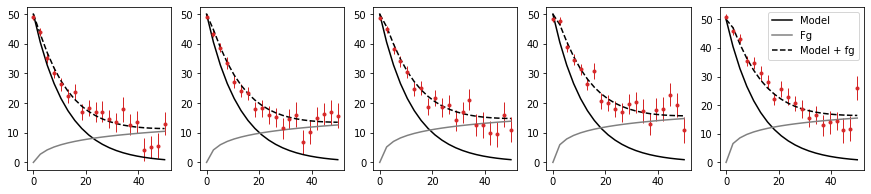

In [31]:
N = 100
n = 5

p1 = 50
p2 = 0.08
pfg = 1.32

# Covariance matrix
cov = generate_covmat(N, n)
invcov = np.linalg.inv(cov)

# X-values
x = np.linspace(0, 50, int(N//n))

# Raw signal
data = compute_model(x, p1, p2, n)
#data = np.array([50 * np.exp(-0.08 * x) for i in range(n)]).flatten()

# Noisy signal
noisy_data = data + svd_pow(cov, 0.5).dot(np.random.randn(len(cov)))

# Split data
split_noisy = split_data(noisy_data, N, n)
split_err = split_data(np.sqrt(cov.diagonal()), N, n)

# Fg data
fg = lin_fg(x, pfg, n)

# Measured data
measured_data = get_measured(data, cov, fg, N, n)

# Plot
fig, axes = plt.subplots(1, n, figsize = (3*n, 3))
for i in range(n):
    axes[i].plot(x, data[:(N//n)], color = "k", label = "Model")
    axes[i].plot(x, fg[i], color = "gray", label = "Fg")
    axes[i].plot(x, data[:(N//n)] + fg[i], color = "k", ls = "--", label = "Model + fg")
    
    axes[i].errorbar(x, measured_data[i], yerr = split_err[i],
                     ls = 'None', marker = '.', elinewidth = 1,
                     color = "tab:red")
l=axes[4].legend()

### Combination of frequencies

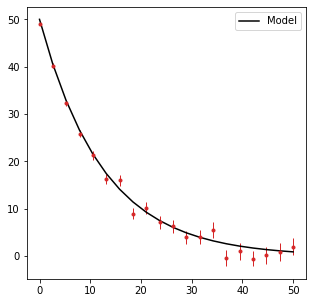

In [32]:
# Produce A matrix
Apart = np.eye(N//n, N//n)
A = [Apart for i in range(n)]
A = np.block(A).T

# Produce Q matrix
Qm1 = A.T.dot(np.linalg.inv(cov)).dot(A)
Q = np.linalg.inv(Qm1)
sqQ = svd_pow(Q, 0.5)

# Get Cb 
def get_Cb(measured, secondary, invcov, Q, A):
    return(Q.dot(A.T).dot(invcov).dot(measured-secondary))

# Example Cb
Cb = get_Cb(np.concatenate(measured_data),
            np.concatenate(fg),
            np.linalg.inv(cov),
            Q, A)

# Plot
plt.figure(figsize = (5,5))

plt.plot(x, data[:(N//n)], color = "k", label = "Model")

plt.errorbar(x, Cb, yerr = np.sqrt(Q.diagonal()),
             ls = 'None', marker = '.', elinewidth = 1,
             color = "tab:red")
l=plt.legend()

### Likelihoods

In [33]:
def logprior_gibbs(par):
    if 0 < par < 3:
        return(1)
    else:
        return(-np.inf)

def logprior_metro(pfg, p1, p2):
    
    if not(0 < pfg < 3):
        return(-np.inf)
    elif not(10 < p1 < 100):
        return(-np.inf)
    elif not(0 < p2 < 0.2):
        return(-np.inf)
    return(1)

def loglike(fg, Cb, measured, invcov):
    
    res = measured - (fg + Cb)
    return(-0.5 * res.dot(invcov).dot(res))

### Gibbs Sampler class

In [34]:
class GibbsSampler:
    
    def __init__(self, Nsteps, invcov, measured):
        self.Nsteps = Nsteps
        self.accepted = []
        self.model = []
        self.accept_rates = []
        self.invcov = invcov
        self.measured_data = np.concatenate(measured)
        
    def acceptance(self, logp, logp_new):
        if logp_new > logp:
            return(True)
        else:
            accept=np.random.uniform(0, 1)
            return(accept < (np.exp(logp_new - logp)))
    
    def proposal(self, last_point):
        
        return(np.random.normal(last_point, 0.1))
    
    def run(self):
        
        current_point = 1.35
        current_fg = np.concatenate(lin_fg(x, current_point, n))
        current_model = data[:20]
        
        accep_count = 0
        
        for i in range(self.Nsteps):
            current_like = loglike(current_fg, A.dot(current_model), self.measured_data, self.invcov)
            current_prior = logprior_gibbs(current_point)
            
            new_point = self.proposal(current_point)
            new_fg = np.concatenate(lin_fg(x, new_point, n))
            
            new_like = loglike(new_fg, A.dot(current_model), self.measured_data, self.invcov)
            new_prior = logprior_gibbs(new_point)
            
            if self.acceptance(current_like + current_prior, new_like + new_prior):
                
                model = get_Cb(self.measured_data, new_fg, self.invcov, Q, A)
                new_model = model + sqQ.dot(np.random.randn(len(model)))
                current_point = new_point
                current_fg = new_fg
                current_model = new_model
                
                self.accepted.append(new_point)
                
                self.model.append(new_model)
                accep_count += 1
            
            else:
                self.accepted.append(current_point)
                self.model.append(current_model)
                
            self.accept_rates.append(accep_count / (i + 1))
        
    def get_acceptance(self):
        return(self.accept_rates)
    
    def get_pars(self):
        return(self.accepted)
    
    def get_model(self):
        return(self.model)

### Metropolis sampler class

In [35]:
class MetropolisSampler:
    
    def __init__(self, Nsteps, invcov, measured):
        self.Nsteps = Nsteps
        self.accepted = []
        self.model = []
        self.accept_rates = []
        self.invcov = invcov
        self.measured_data = np.concatenate(measured)
        
    def acceptance(self, logp, logp_new):
        if logp_new > logp:
            return(True)
        else:
            accept=np.random.uniform(0, 1)
            return(accept < (np.exp(logp_new - logp)))
    
    def proposal(self, last_point):
        
        pfg = np.random.normal(last_point[0], 0.1)
        p1 = np.random.normal(last_point[1], 0.1)
        p2 = np.random.normal(last_point[2], 0.005)
        
        return([pfg, p1, p2])
    
    def run(self):
        
        current_point = [1.35, 35, 0.06]
        current_fg = np.concatenate(lin_fg(x, current_point[0], n))
        current_model = compute_model(x, current_point[1], current_point[2], n)
        
        accep_count = 0
        
        for i in range(self.Nsteps):
            current_like = loglike(current_fg, current_model, self.measured_data, self.invcov)
            current_prior = logprior_metro(current_point[0], current_point[1], current_point[2])
            
            new_point = self.proposal(current_point)
            new_fg = np.concatenate(lin_fg(x, new_point[0], n))
            new_model = compute_model(x, new_point[1], new_point[2], n)
            
            new_like = loglike(new_fg, new_model, self.measured_data, self.invcov)
            new_prior = logprior_metro(new_point[0], new_point[1], new_point[2])
            
            if self.acceptance(current_like + current_prior, new_like + new_prior):
                
                current_point = new_point
                current_fg = new_fg
                current_model = new_model
                
                self.accepted.append(new_point)
                
                self.model.append(new_model)
                accep_count += 1
            
            else:
                self.accepted.append(current_point)
                self.model.append(current_model)
                
            self.accept_rates.append(accep_count / (i + 1))
        
    def get_acceptance(self):
        return(self.accept_rates)
    def get_pars(self):
        return(self.accepted)
    def get_model(self):
        return(self.model)

### Sampling

In [36]:
sampler = GibbsSampler(400000, invcov, measured_data)
sampler.run()

In [37]:
samplerM = MetropolisSampler(400000, invcov, measured_data)
samplerM.run()

### Results

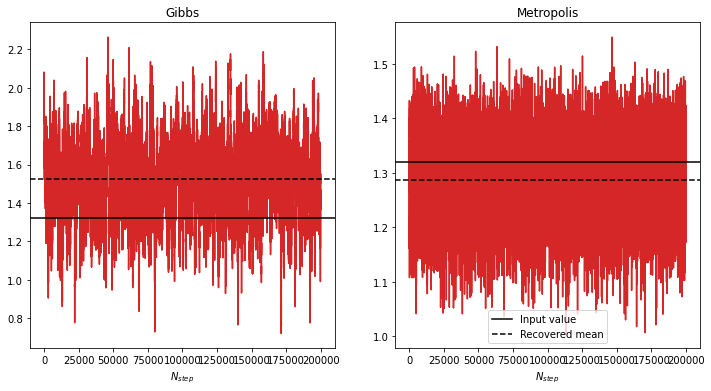

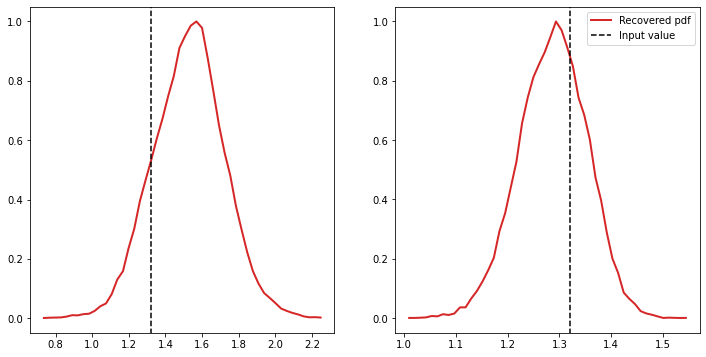

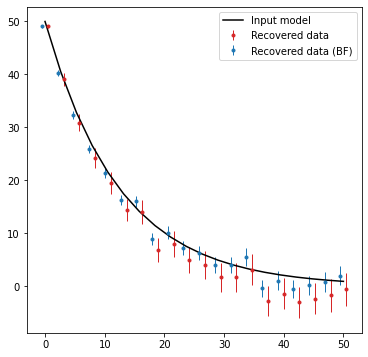

In [38]:
chain = sampler.get_pars()
chainM = np.array(samplerM.get_pars())[:, 0]

# Burn-in
chain = chain[len(chain)//2:]
chainM = chainM[len(chainM)//2:]

fig, axes = plt.subplots(1, 2, figsize = (12, 6))
axes[0].plot(chain, color = "tab:red")
axes[0].axhline(pfg, xmin = -50, xmax = +1e6, color = "k", label = "Input value")
axes[0].axhline(np.mean(chain), color = "k", ls = "--", label = "Recovered mean")
axes[0].set_xlabel(r"$N_{step}$")
axes[0].set_title("Gibbs")
axes[1].plot(chainM, color = "tab:red")
axes[1].axhline(pfg, xmin = -50, xmax = +1e6, color = "k", label = "Input value")
axes[1].axhline(np.mean(chainM), color = "k", ls = "--", label = "Recovered mean")
axes[1].set_xlabel(r"$N_{step}$")
axes[1].set_title("Metropolis")
axes[1].legend()

fig, axes = plt.subplots(1, 2, figsize = (12, 6))

hist, bins = np.histogram(chain, bins = 50)
bins = [(bins[i] + bins[i+1])/2 for i in range(len(bins) - 1)]

histM, binsM = np.histogram(chainM, bins = 50)
binsM = [(binsM[i] + binsM[i+1]) / 2 for i in range(len(binsM) - 1)]

axes[0].plot(bins, hist/np.max(hist), color = "tab:red", lw = 2, label = "Recovered pdf")
axes[0].axvline(pfg, ymin = -5, ymax = +5, color = "k", ls = "--", label = "Input value")

axes[1].plot(binsM, histM/np.max(histM), color = "tab:red", lw = 2, label = "Recovered pdf")
axes[1].axvline(pfg, ymin = -5, ymax = +5, color = "k", ls = "--", label = "Input value")
axes[1].legend()

plt.figure(figsize = (6, 6))
plt.plot(x, data[:20], color = "k", label = "Input model")
plt.errorbar(x+0.5, np.mean(np.array(sampler.get_model()), axis = 0),
             yerr = np.std(np.array(sampler.get_model()), axis = 0),
             ls = "None", color = "tab:red", marker = ".",
             elinewidth = 1, label = "Recovered data")
plt.errorbar(x-0.5, Cb, yerr = np.sqrt(Q.diagonal()),
             ls = 'None', marker = '.', elinewidth = 1,
             color = "tab:blue", label = "Recovered data (BF)")
plt.legend()

### Do we recover input value ?

<ipython-input-2-ebc47aac7887>:29: RuntimeWarning: invalid value encountered in log
  return(np.array([2.4*par*np.log(1 + par * (2*(i+1)/n)*x) for i in range(n)]))


Distance to input : 0.12849212607594626


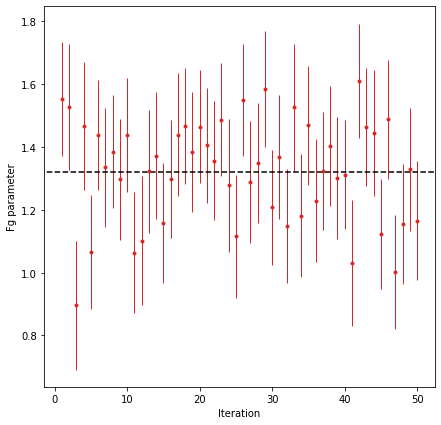

In [11]:
Nchains = 50

means = []
stds = []
for i in range(Nchains):
    mdata = get_measured(data, cov, fg, N, n)
    
    s = GibbsSampler(35000, np.linalg.inv(cov), mdata)
    s.run()
    
    means.append(np.mean(s.get_pars()))
    stds.append(np.std(s.get_pars()))
    
recovered_Nchains = np.mean(means)
std_Nchains = np.mean(stds) / np.sqrt(Nchains)

print("Distance to input : {}".format(np.abs(recovered_Nchains - pfg) / std_Nchains))

plt.figure(figsize = (7, 7))
plt.axhline(pfg, xmin = -1, xmax = 2 * Nchains, color = "k", ls = "--")
plt.errorbar(np.arange(1, len(means) + 1), means, yerr = stds,
             ls = "None", marker = ".", elinewidth = 1, color = "tab:red")
plt.xlabel("Iteration")
plt.ylabel("Fg parameter")
plt.show()

In [13]:

print(means)
print(np.mean(stds))
print(np.mean(means))

[1.55269881327468, 1.5283133095930181, 0.895808233145328, 1.4662883592835876, 1.0660224562703797, 1.43921680591763, 1.3354014535269116, 1.3847590195347586, 1.2970490756427373, 1.4382813784933666, 1.0640400711472462, 1.1023008162149093, 1.3228871005919742, 1.3725789204868408, 1.1574372388840666, 1.2987761290771225, 1.4389429385934185, 1.466982431414649, 1.383548263186424, 1.4645517232856162, 1.4055889655614517, 1.356948547115481, 1.486385131170047, 1.2781880913614665, 1.1154719107940592, 1.5499387589015863, 1.2888638356333122, 1.3488844970221705, 1.585342385415291, 1.2076586320493756, 1.3669639035709404, 1.1475274719315207, 1.5271095064194276, 1.180874246716441, 1.4689522960281234, 1.2292017648423599, 1.324165076975035, 1.4023795398851813, 1.30156046571862, 1.3111145621094615, 1.0308245718148705, 1.611395799401997, 1.4650783881483762, 1.443372892381006, 1.1229885973345348, 1.4877114137094298, 1.0024338624653293, 1.1551289851052733, 1.3293720958506723, 1.1654306982007074]
0.1901231478105